In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import pandas as pd
%matplotlib inline

import json
import os
import page_ranker as pr
import inspect_subgraph as isg

#from matplotlib.animation import ImageMagickWriter

In [2]:
cwd = os.getcwd()

dir_as_list = cwd.split('/')
base_path=''
go = True
i=0
while go:
    base_path= base_path+dir_as_list[i]+'/'
    if dir_as_list[i]=='GitHub':
        go = False
    i=i+1
    
rel_path = "research/sample-graphs/sourcecred_research.json"

abs_file_path = os.path.abspath(os.path.join(base_path, rel_path))

In [3]:
import sys
infra_path = 'infra/'
sys.path.insert(0, os.path.join(base_path, infra_path))
import import_graph as ig #this accesses Dandelion's version; there's also a local version

In [4]:
with open(abs_file_path) as json_file:  
    data = json.load(json_file)
    
base_graph = ig.json_to_graph(data)

In [5]:
node_types = {base_graph.node[n]['type'] for n in base_graph.nodes }
print(node_types)

{'github/repo', 'github/review', 'git/commit', 'github/comment', 'github/issue', 'github/user', 'github/pull'}


In [6]:
edge_types = {base_graph.edges[e]['type'] for e in base_graph.edges }
print(edge_types)

{'github/mentionsAuthor', 'github/references', 'github/authors', 'git/hasParent', 'github/hasParent', 'github/mergedAs'}


In [7]:
#helper functions
def get_nodes_by_type(g, node_type_selection):
    return [node for node in g.nodes if g.nodes[node]['type']== node_type_selection ]

def get_edges_by_type(g, edge_type_selection):
    return [edge for edge in g.edges if g.edges[edge]['type']== edge_type_selection ]

def edge_count(g,src,dst):
    i =0
    stop = False
    while not(stop):
        try:
            g.edges[(src,dst,i)]
            i=i+1
        except:
            stop = True
            return i

In [8]:
#sample comment
base_graph.nodes[get_nodes_by_type(base_graph, 'github/comment')[0]]

{'address': ('sourcecred',
  'github',
  'COMMENT',
  'ISSUE',
  'sourcecred',
  'research',
  '5',
  '468081422'),
 'type': 'github/comment'}

In [9]:
#sample author edge
ex_auth_edge = get_edges_by_type(base_graph, 'github/authors')[0]
print(ex_auth_edge)
print(base_graph.nodes[ex_auth_edge[0]])
base_graph.edges[ex_auth_edge]

(33, 18, 0)
{'address': ('sourcecred', 'github', 'USERLIKE', 'USER', 'BrianLitwin'), 'type': 'github/user'}


{'address': ('sourcecred',
  'github',
  'AUTHORS',
  '5',
  'sourcecred',
  'github',
  'USERLIKE',
  'USER',
  'BrianLitwin',
  '6',
  'sourcecred',
  'github',
  'ISSUE',
  'sourcecred',
  'research',
  '2'),
 'type': 'github/authors'}

In [10]:
#sample has parent edge
ex_parent_edge = get_edges_by_type(base_graph, 'github/hasParent')[0]
print(ex_parent_edge)
print(base_graph.nodes[ex_parent_edge[0]])
base_graph.edges[ex_parent_edge]

(3, 20, 0)
{'address': ('sourcecred', 'github', 'COMMENT', 'ISSUE', 'sourcecred', 'research', '5', '468081422'), 'type': 'github/comment'}


{'address': ('sourcecred',
  'github',
  'HAS_PARENT',
  '8',
  'sourcecred',
  'github',
  'COMMENT',
  'ISSUE',
  'sourcecred',
  'research',
  '5',
  '468081422'),
 'type': 'github/hasParent'}

In [11]:
#need the ability to add contributions
def synthetic_random_comment(g, author_input='random'):
    graph=g.copy()
    
    new_node_id = len(graph.nodes)
    graph.add_node(new_node_id)
    graph.nodes[new_node_id]["type"] = 'github/comment'
    graph.nodes[new_node_id]["address"] = ('sythethic')
    
    #pick an author
    author_candidates = get_nodes_by_type(graph, 'github/user')
    if author_input in author_candidates:
        author = author_input
    else:
        author = np.random.choice(author_candidates)
    
    author_edge_id = (author, new_node_id, edge_count(graph,author,new_node_id))
    graph.add_edge(author, new_node_id)
    graph.edges[author_edge_id]['type'] = 'github/authors'
    graph.edges[author_edge_id]['address'] = ('sythethic')
    
    #pick the thing being commented on
    commented_on_candidates = get_nodes_by_type(graph, 'github/comment') \
        + get_nodes_by_type(graph, 'github/review')\
        + get_nodes_by_type(graph, 'github/issue')  
    
    commented_on =  np.random.choice(commented_on_candidates)
    commented_on_edge_id = (new_node_id, commented_on, edge_count(graph,new_node_id, commented_on))
    graph.add_edge(new_node_id,commented_on)
    graph.edges[commented_on_edge_id]['type'] = 'github/hasParent'
    graph.edges[commented_on_edge_id]['address'] = ('sythethic')
    
    
    #pick some references
    refs_candidates =  get_nodes_by_type(graph, 'github/issue') \
        + get_nodes_by_type(graph, 'github/user') \
        + get_nodes_by_type(graph, 'github/review')
    
    #number of references
    mu = 2 #expected number of references
    num_refs = sts.poisson.rvs(mu)
    
    refs = np.random.choice(refs_candidates,2, replace=False)
    for ref in refs:
        if graph.nodes[ref]["type"] == 'github/user':
            ref_type = 'github/mentionsAuthor'
        else :
            ref_type ='github/references'
        
        ref_edge_id = (new_node_id, ref, edge_count(graph,new_node_id, ref))
        graph.add_edge(new_node_id,ref)
        graph.edges[ref_edge_id]['type'] = ref_type
        graph.edges[ref_edge_id]['address'] = ('sythethic')
    
    return graph

In [12]:
def synthetic_new_user(g, include_comment= True):
    graph=g.copy()
    new_node_id = len(graph.nodes)
    graph.add_node(new_node_id)
    graph.nodes[new_node_id]["type"] = 'github/user'
    graph.nodes[new_node_id]["address"] = ('sythethic','','','','SyntheticUser'+str(new_node_id))
    
    if include_comment:
        graph = synthetic_random_comment(graph, author_input=new_node_id)
    
    return graph
    

In [13]:
synthetic_new_user(base_graph)

In [14]:
nodes = [n for n in base_graph.nodes]

In [15]:
base_graph.nodes[nodes[-2]]

{'address': ('sourcecred', 'github', 'USERLIKE', 'USER', 'mzargham'),
 'type': 'github/user'}

Text(0.5, 1.0, 'SourceCred/Research')

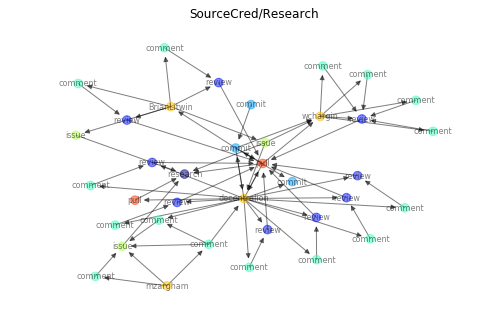

In [16]:
isg.inspectSubGraph(base_graph, nodes)
plt.title("SourceCred/Research")

Text(0.5, 1.0, 'Simplifed SourceCred/Research Subgraph = $G_0$')

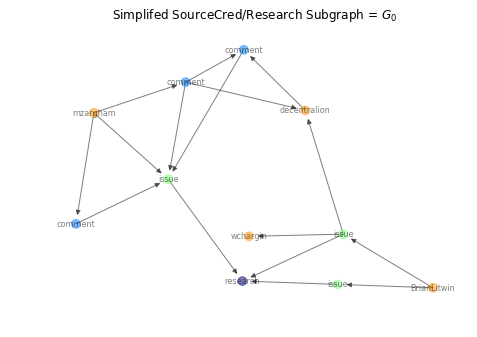

In [17]:
subgraph = isg.inspectSubGraph(base_graph, get_nodes_by_type(base_graph, 'github/issue'))
plt.title("Simplifed SourceCred/Research Subgraph = $G_0$")

In [18]:
smaller_base_graph = nx.convert_node_labels_to_integers(subgraph, first_label=0)

g0 = smaller_base_graph.copy()
g1 = synthetic_new_user(g0, include_comment= True)

Text(0.5, 1.0, "New Synthetic user Comment on Decentralion's Prior Comment:\n mentions mZargham and Decentralion")

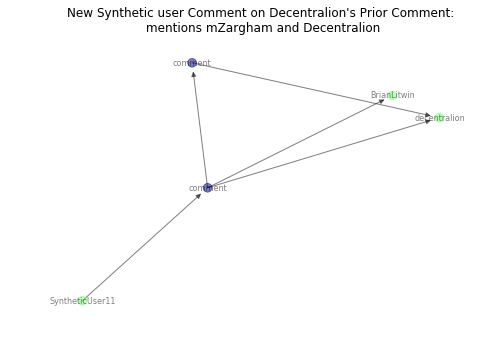

In [19]:
isg.inspectSubGraph(g1, [node for node in g1.nodes][-2:], expand = True)
plt.title("New Synthetic user Comment on Decentralion's Prior Comment:\n mentions mZargham and Decentralion")

In [20]:
T = 50 #iterations of graph update in our simulation

#set up the pagerank algorithm params
iterations = 25

alpha = .01
seed = {n:0.0 for n in base_graph.nodes}
source_id = get_nodes_by_type(smaller_base_graph, 'github/repo')[0]
seed[source_id]=1.0 #source_id is the repo itself
self_loop_wt = 1/10004

#memory coef of time weighted cred
gamma = .9

In [21]:
_,_, network= pr.pageRanker(smaller_base_graph,
                         alpha,
                         iterations,
                         seed=seed,
                         initial_value = seed,
                         lazy=True,
                         self_loop_wt=self_loop_wt)

In [22]:
for node in network.nodes:
    network.nodes[node]['cumulative']= network.nodes[node]['score']
    network.nodes[node]['time_weighted']=network.nodes[node]['score']

In [23]:
def drop_and_normalize(vec, drop_bunch):
    for node in drop_bunch:
        vec[node]=0
    
    new_total = sum(vec)
    return vec/new_total

def indicator_of(graph, node):
    seed = {n:0.0 for n in graph.nodes}
    seed[node]=1.0 #source_id is the repo itself
    return seed

In [24]:
scores = np.array([network.nodes[node]['score'] for node in network.nodes])
cred = drop_and_normalize(scores, [source_id])

Text(0.5, 1.0, 'Personalized PageRank with seed sourcecred/research')

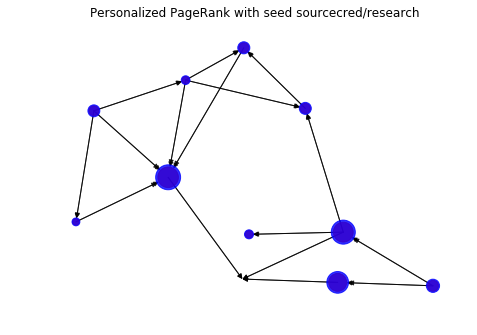

In [25]:
scale=2500

nx.draw_kamada_kawai(network, node_size=scores*scale, alpha=.8)
nx.draw_kamada_kawai(network, node_size=cred*scale, alpha=.8, node_color='b')
plt.title("Personalized PageRank with seed sourcecred/research")

In [26]:
network.nodes[0]

{'address': ('sourcecred', 'github', 'USERLIKE', 'USER', 'BrianLitwin'),
 'type': 'github/user',
 'color': (1.0, 0.5816993464052289, 0.0, 1.0),
 'label': 'BrianLitwin',
 'score': 0.047760156485161666,
 'all_nbr': {7, 8},
 'in_nbr': set(),
 'out_nbr': {7, 8},
 'self_wt': 9.996001599360256e-05,
 'total_wt': 2.0000999600159934,
 'cumulative': 0.047760156485161666,
 'time_weighted': 0.047760156485161666}

(array([2., 2., 4., 0., 0., 0., 0., 1., 0., 2.]),
 array([0.        , 0.02487285, 0.0497457 , 0.07461855, 0.0994914 ,
        0.12436425, 0.1492371 , 0.17410995, 0.1989828 , 0.22385565,
        0.2487285 ]),
 <a list of 10 Patch objects>)

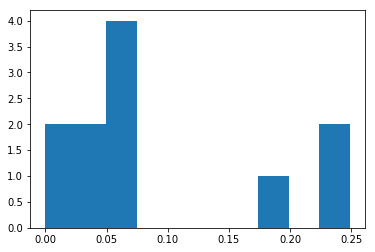

In [27]:
plt.hist(cred)

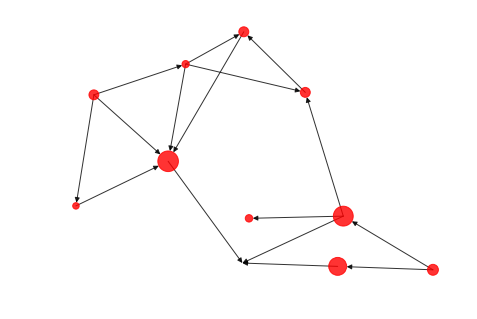

In [28]:

nx.draw_kamada_kawai(network, node_size=scores*scale, alpha=.8)

In [29]:
for node in network.nodes:
    print(network.nodes[node]['cumulative'])

0.047760156485161666
0.03946556774186552
0.020897886169731095
0.039852462510800525
0.03893956062101374
0.016939929153401815
0.02232470711821712
0.12854041573228447
0.15772689869128453
0.16965945837705845
0.31789295739918205


In [30]:
initial_conditions = {'cred':cred,
                      'cumulative_cred':cred,
                      'time_weighted_cred':cred,
                      'network':network}

In [31]:
def update_network(params, step, sL, s, _input):
    
    prior_network = s['network']
    
    if _input['new_user']:
        new_network = synthetic_new_user(prior_network)
    else:
        new_network = synthetic_random_comment(prior_network)
    
    _,_,new_network = pr.pageRanker(new_network,
                         alpha,
                         iterations,
                         seed=indicator_of(new_network,source_id),
                         initial_value = indicator_of(new_network,source_id),
                         lazy=True,
                         self_loop_wt=self_loop_wt)
    
    for node in new_network.nodes:
        if node in prior_network.nodes:
            new_network.nodes[node]['cumulative']=prior_network.nodes[node]['cumulative']\
                +new_network.nodes[node]['score']
            new_network.nodes[node]['time_weighted']=gamma*prior_network.nodes[node]['time_weighted']\
                +(1-gamma)*new_network.nodes[node]['score']
        else:
            new_network.nodes[node]['cumulative']= new_network.nodes[node]['score']
            new_network.nodes[node]['time_weighted']=new_network.nodes[node]['score']
    
    key = 'network'
    value = new_network 
    
    return (key, value)

In [32]:
def update_cred(params, step, sL, s, _input):
    
    network = s['network']
    scores = np.array([network.nodes[node]['score'] for node in network.nodes])
    cred = drop_and_normalize(scores, [source_id])
    
    key = 'cred'
    value = cred
    
    return (key, value)

def update_cumulative(params, step, sL, s, _input):
    
    network = s['network']
    cumulative_cred = np.array([network.nodes[node]['cumulative'] for node in network.nodes])
    #cumulative_cred = drop_and_normalize(cumulative, [source_id])
    
    key = 'cumulative_cred'
    value = cumulative_cred
    
    return (key, value)

def update_time_weighted(params, step, sL, s, _input):
    
    network = s['network']
    time_weighted_cred = np.array([network.nodes[node]['time_weighted'] for node in network.nodes])
    #time_weighted_cred = drop_and_normalize(time_weighted, [source_id])
    
    key = 'time_weighted_cred'
    value = time_weighted_cred
    
    return (key, value)

In [33]:
def random_contribution(params, step, sL, s):
    
    network = s['network']
    users = get_nodes_by_type(network, 'github/user')
    num_users = len(users)
    
    max_users = 50
    rv = np.random.uniform(0,1)
    #probability of new user ~ .2
    thresh = .2
    new_user = bool(rv<thresh)

    return({'new_user':new_user})

In [34]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #The following policy functions will be evaluated 
            #and their returns will be passed to the state update functions
            'random': random_contribution
        },
        'variables': { # The following state variables will be updated simultaneously
            'network': update_network
            
        }
    },
    {
      'policies': {
          #Updates in this block are entirely state dependent in this version
        },
        'variables': { # The following state variables will be updated simultaneously
            'cred': update_cred,
            'cumulative_cred': update_cumulative,
            'time_weighted_cred':update_time_weighted
        }
    }
]

In [35]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(T),
    'N': 1,
    'M': {}
}

In [36]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [37]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x1a27b3c5c0>]


In [38]:
df = pd.DataFrame(raw_result)

In [39]:
df.head()

cred  \
0  [0.07001856527247696, 0.057858320288537865, 0....   
1  [0.07001856527247696, 0.057858320288537865, 0....   
2  [0.06958144399968927, 0.06416827285204604, 0.0...   
3  [0.06958144399968927, 0.06416827285204604, 0.0...   
4  [0.06791312665052263, 0.06611420825626564, 0.0...   

                                     cumulative_cred  \
0  [0.07001856527247696, 0.057858320288537865, 0....   
1  [0.07001856527247696, 0.057858320288537865, 0....   
2  [0.09582370795773174, 0.083789958094328, 0.038...   
3  [0.09582370795773174, 0.083789958094328, 0.038...   
4  [0.14311993209471474, 0.1298333751264821, 0.05...   

                                      network  run  substep  \
0          (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)    1        0   
1      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)    1        1   
2      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)    1        2   
3  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)    1        1   
4  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)    1        2   

                                  time_weighted_cred  timestep  
0  [0.07001856527247696, 0.057858320288537865, 0....         0  
1  [0.07001856527247696, 0.057858320288537865, 0....         1  
2  [0.0477904959839025, 0.039951450002925215, 0.0...         1  
3  [0.0477904959839025, 0.039951450002925215, 0.0...         2  
4  [0.047741068799210556, 0.0405606467058481, 0.0...         2

In [40]:
nets = df[df.substep==1].network.values
pos = nx.kamada_kawai_layout(nets[-1])

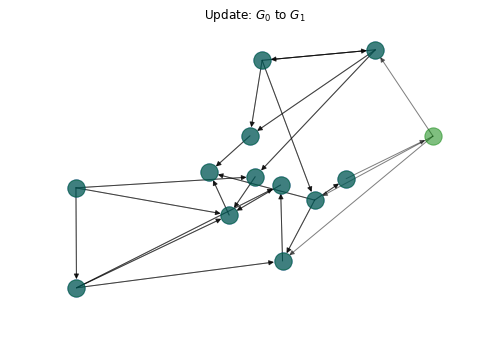

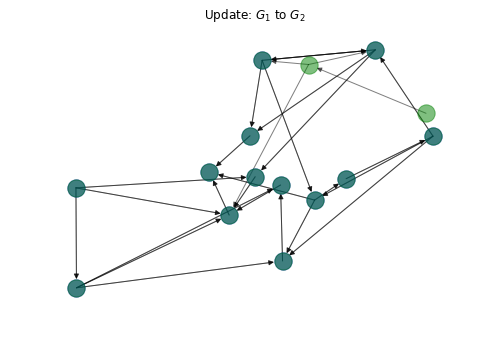

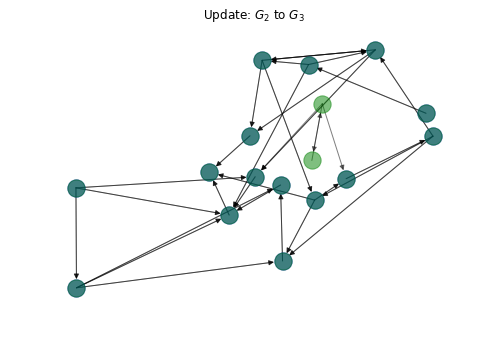

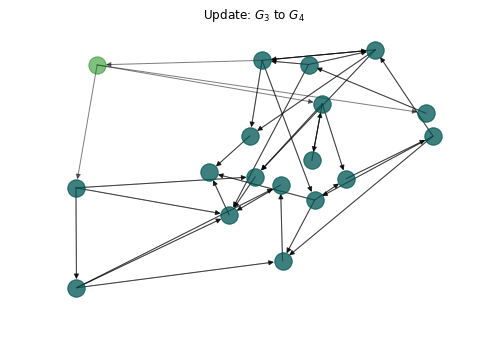

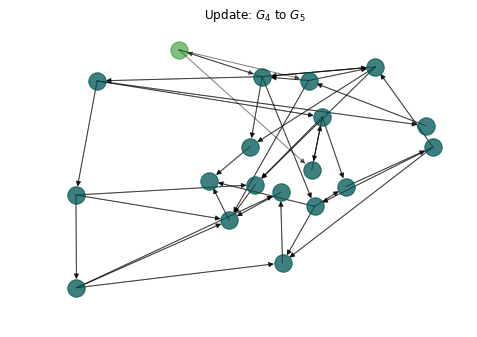

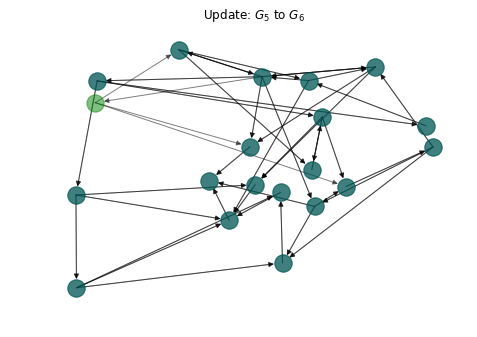

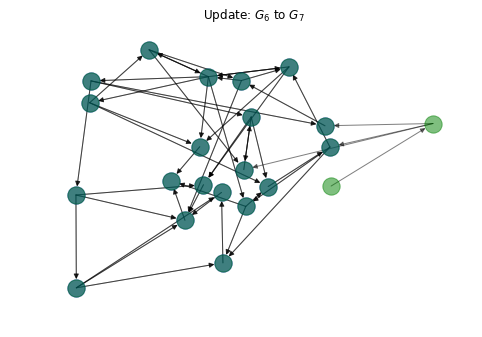

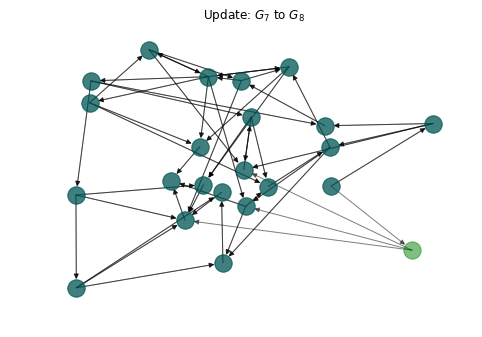

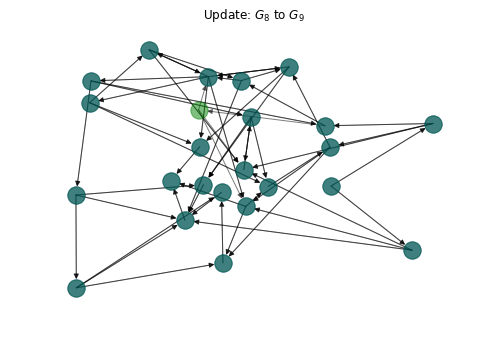

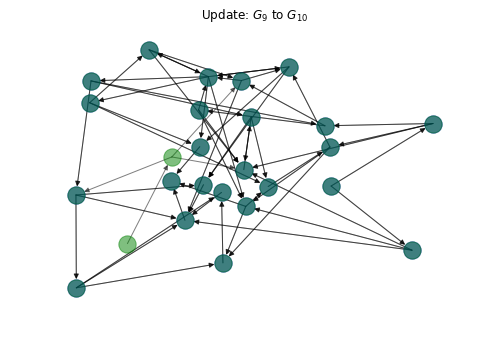

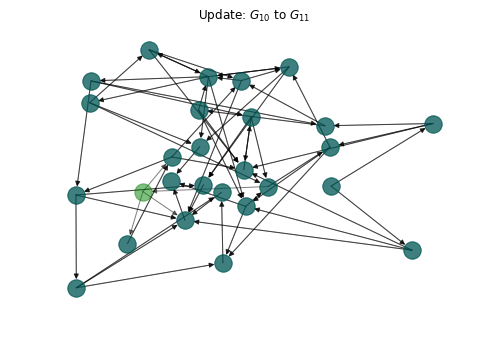

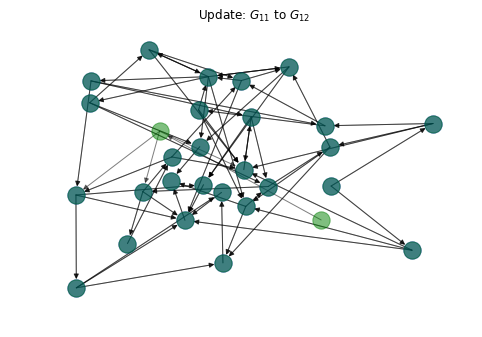

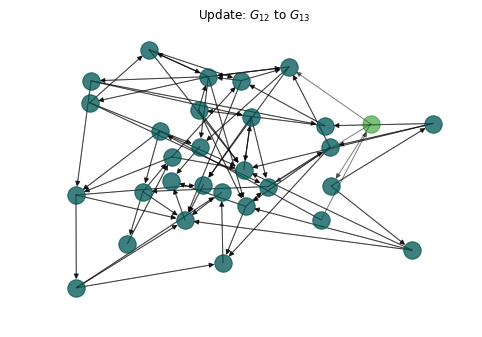

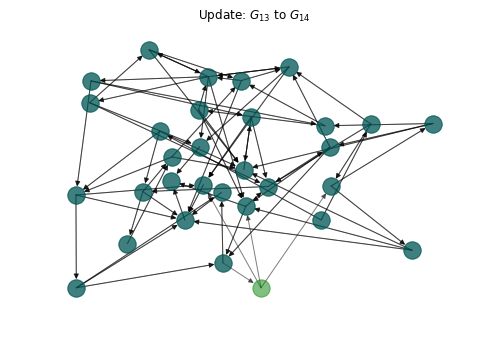

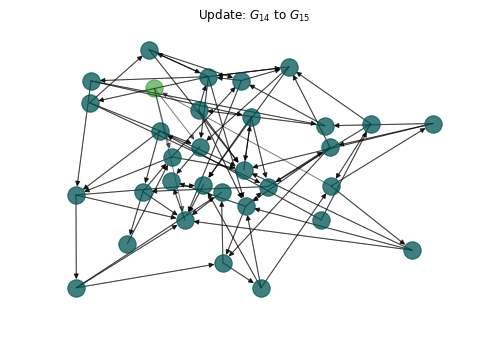

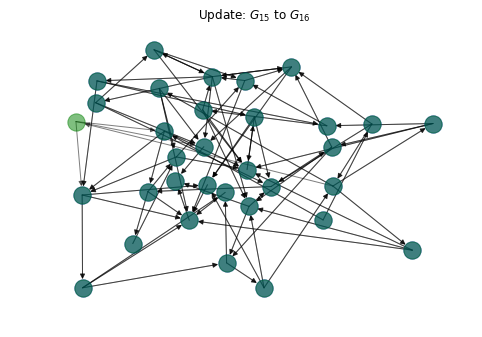

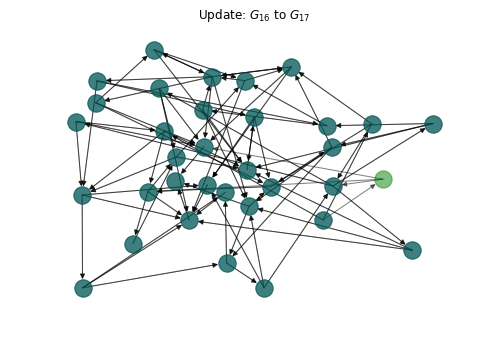

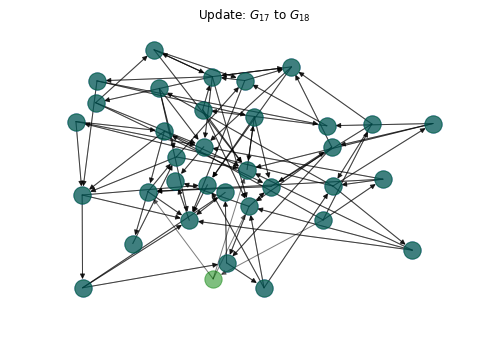

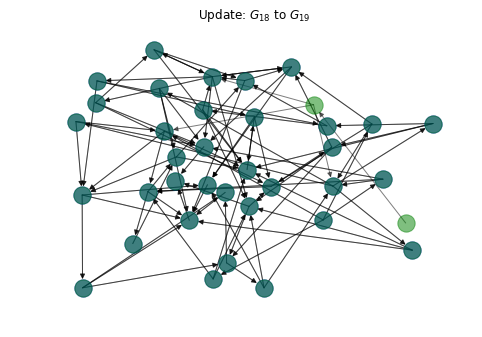

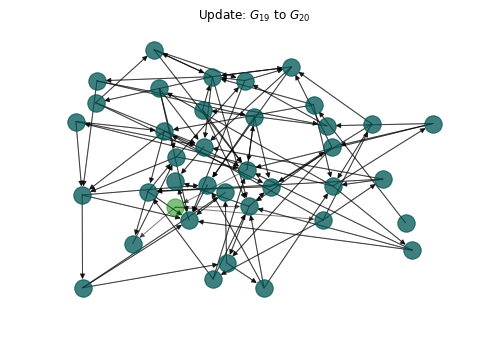

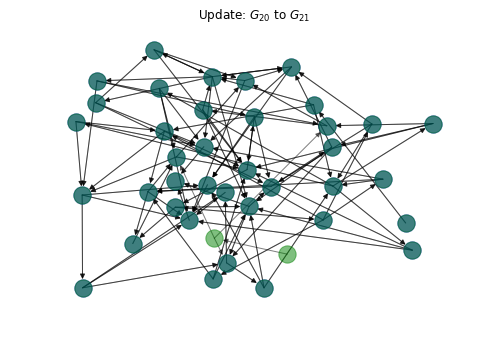

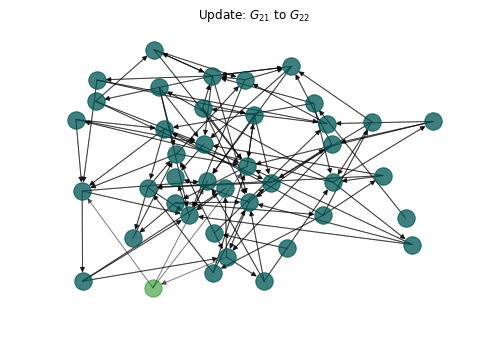

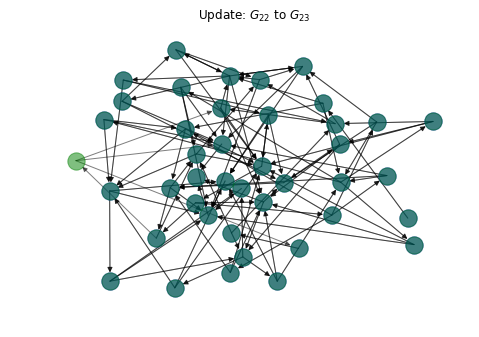

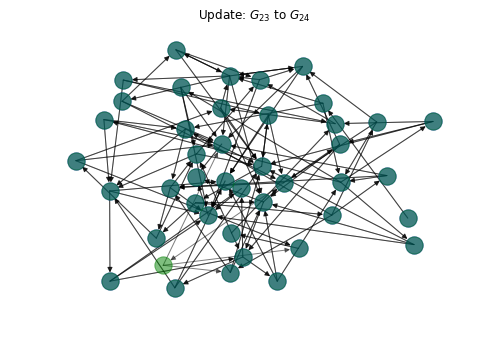

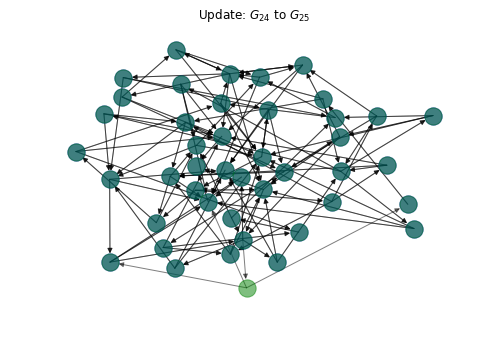

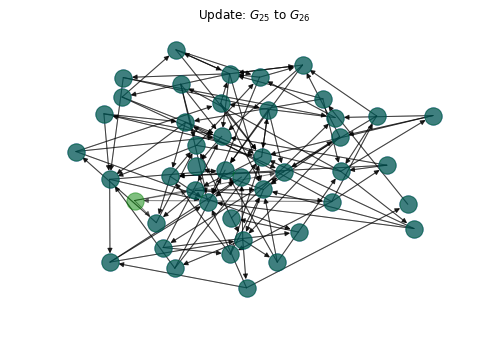

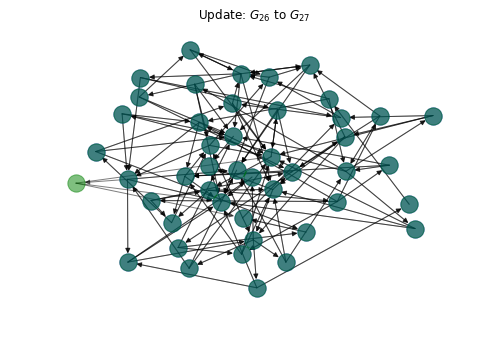

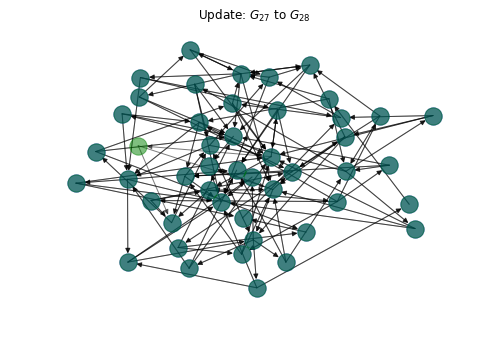

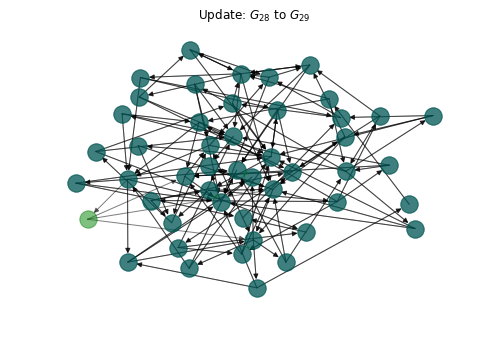

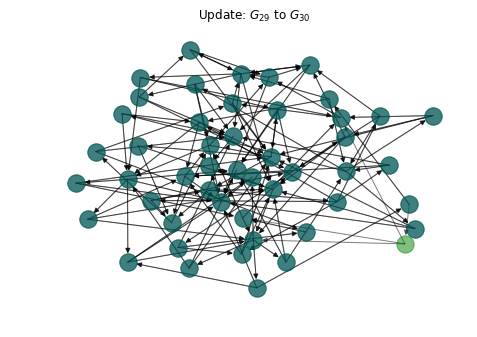

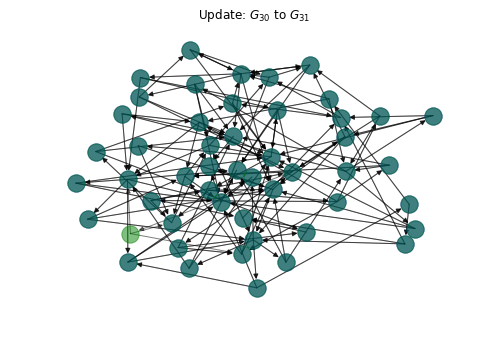

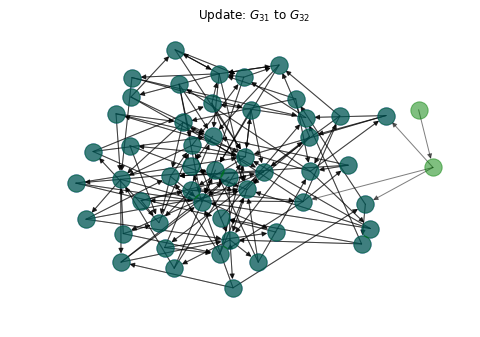

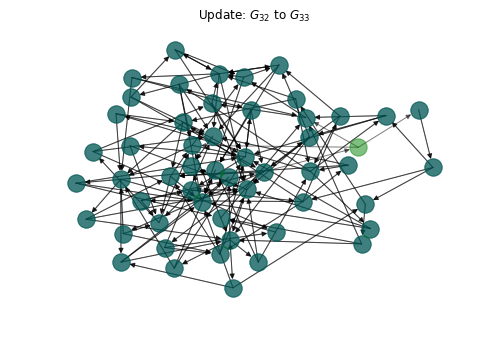

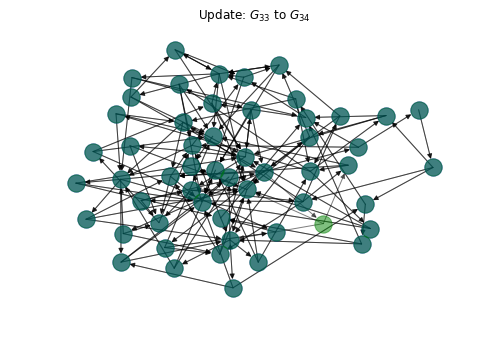

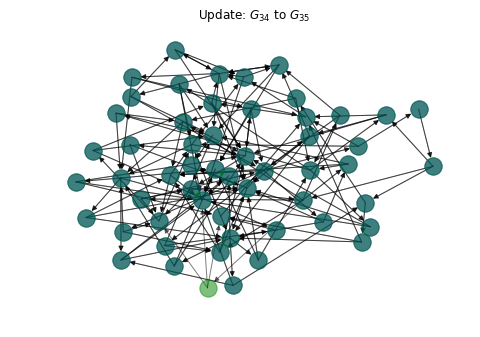

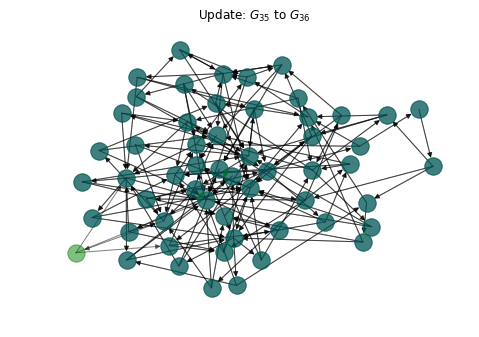

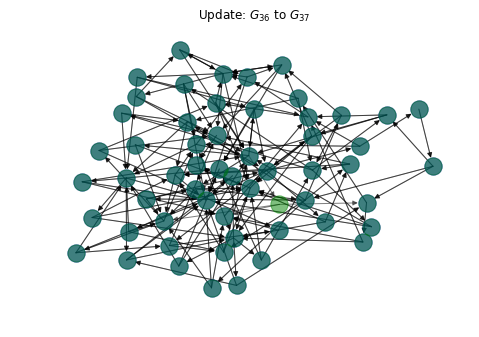

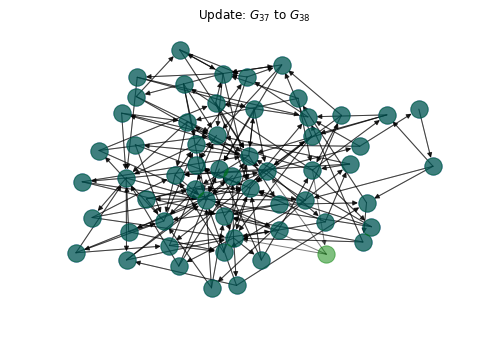

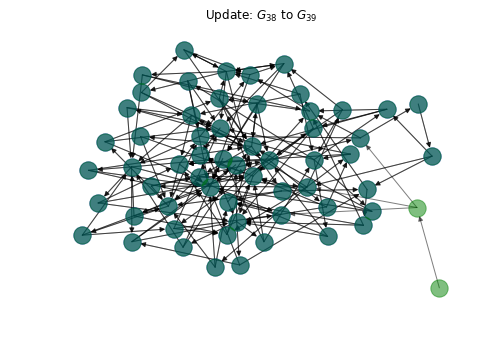

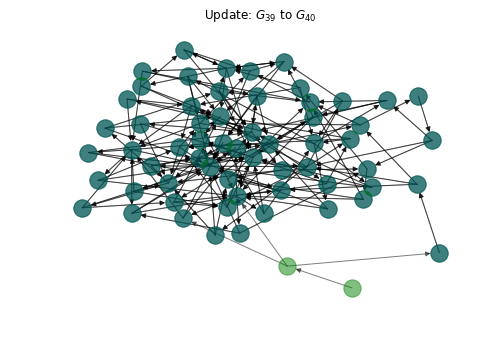

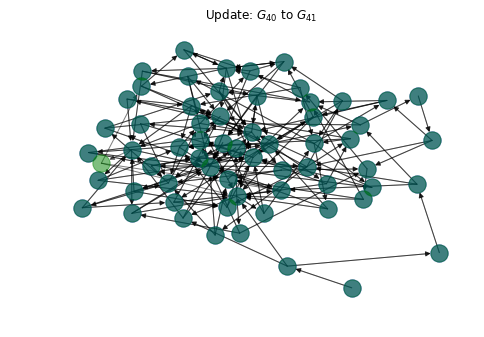

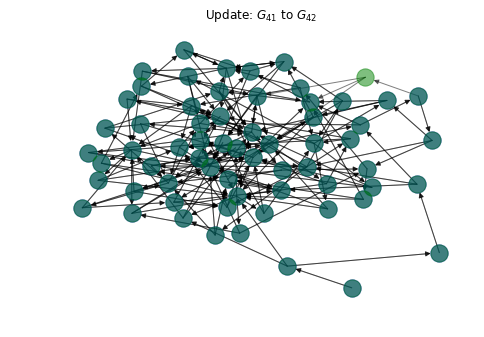

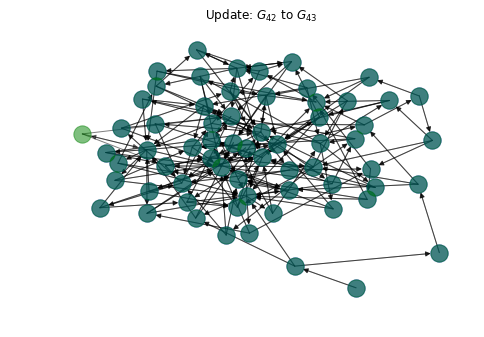

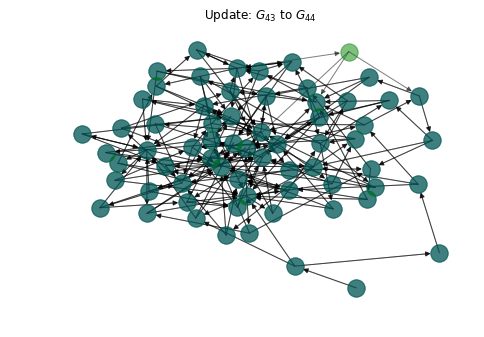

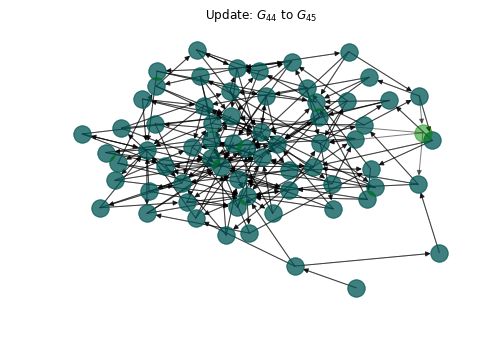

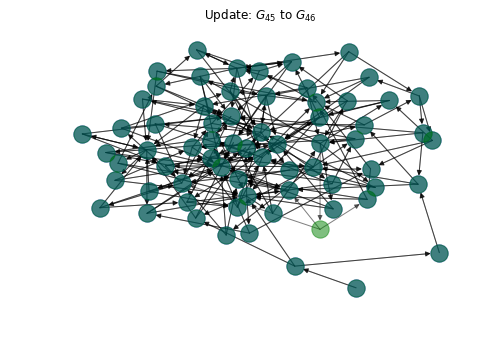

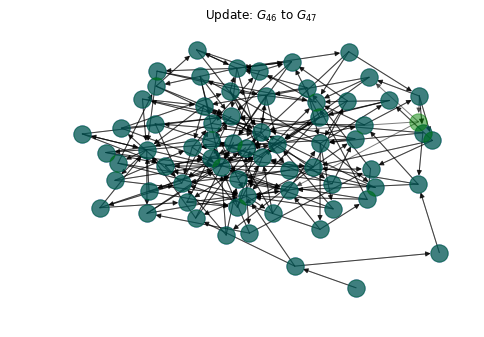

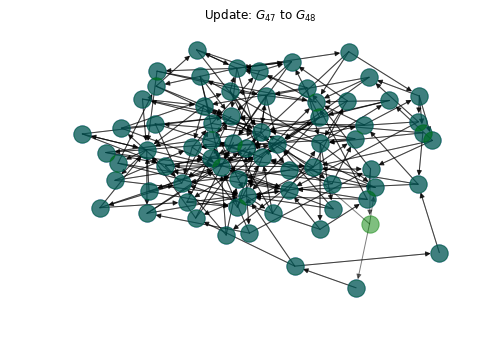

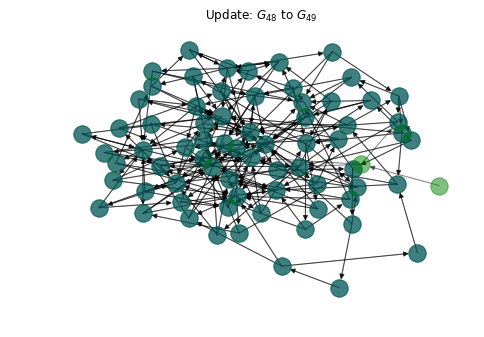

In [77]:
for i in range(len(nets)-1):
    nx.draw(nets[i],pos=pos, alpha=.5, node_color='b')
    nx.draw(nets[i+1],pos=pos,  alpha=.5, node_color='g')
    plt.title("Update: $G_{"+str(i)+"}$ to $G_{"+str(i+1)+"}$")
    plt.show()

In [42]:
df['node_count'] = df.network.apply(lambda x: len(x.nodes))
df['edge_count'] = df.network.apply(lambda x: len(x.edges))
df['user_count'] = df.network.apply(lambda x: len(get_nodes_by_type(x, 'github/user')))

In [59]:
df.head()

cred  \
0  [0.07001856527247696, 0.057858320288537865, 0....   
1  [0.07001856527247696, 0.057858320288537865, 0....   
2  [0.07534469335075676, 0.05521551921623299, 0.0...   
3  [0.07534469335075676, 0.05521551921623299, 0.0...   
4  [0.07240542509332236, 0.05825145940997595, 0.0...   

                                     cumulative_cred  \
0  [0.07001856527247696, 0.057858320288537865, 0....   
1  [0.07001856527247696, 0.057858320288537865, 0....   
2  [0.0996831812410881, 0.0775167780351914, 0.041...   
3  [0.0996831812410881, 0.0775167780351914, 0.041...   
4  [0.15049440428302882, 0.11839531569703045, 0.0...   

                                      network  run  substep  \
0          (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)    1        0   
1      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)    1        1   
2      (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)    1        2   
3  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)    1        1   
4  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)    1        2   

                                  time_weighted_cred  timestep  node_count  \
0  [0.07001856527247696, 0.057858320288537865, 0....         0          11   
1  [0.07001856527247696, 0.057858320288537865, 0....         1          12   
2  [0.048176443312238144, 0.039324131997011555, 0...         1          12   
3  [0.048176443312238144, 0.039324131997011555, 0...         2          13   
4  [0.0484399212852084, 0.039479572563494304, 0.0...         2          13   

   edge_count  user_count                                        padded_cred  
0          16           4  [0.07001856527247696, 0.057858320288537865, 0....  
1          20           4  [0.07001856527247696, 0.057858320288537865, 0....  
2          20           4  [0.07534469335075676, 0.05521551921623299, 0.0...  
3          24           4  [0.07534469335075676, 0.05521551921623299, 0.0...  
4          24           4  [0.07240542509332236, 0.05825145940997595, 0.0...

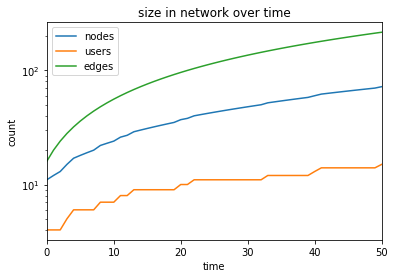

In [63]:
df.plot(x='timestep', y=['node_count', 'user_count', 'edge_count'], logy=True)
#df.plot(x='timestep', y='user_count')
#df.plot(x='timestep', y='edge_count')
plt.title('size in network over time')
plt.xlabel('time')
plt.ylabel('count')
plt.legend(["nodes","users","edges"])


In [64]:
def pad(vec, length,fill=True):
    
    if fill:
        padded = np.zeros(length,)
    else:
        padded = np.empty(length,)
        padded[:] = np.nan
        
    for i in range(len(vec)):
        padded[i]= vec[i]
        
    return padded

def make2D(key, data, fill=False):
    maxL = data[key].apply(len).max()
    newkey = 'padded_'+key
    data[newkey] = data[key].apply(lambda x: pad(x,maxL,fill))
    reshaped = np.array([a for a in data[newkey].values])
    
    return reshaped

Text(0, 0.5, 'pagerank($G_t$)')

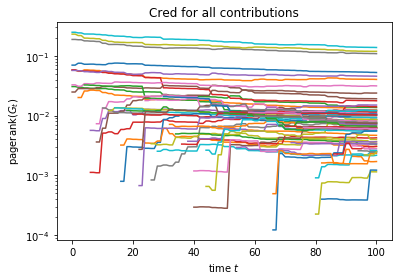

In [65]:
plt.semilogy(df.index,make2D('cred', df, False))
plt.title('Cred for all contributions')
plt.xlabel('time $t$')
plt.ylabel('pagerank($G_t$)')

Text(0, 0.5, 'exponentiall smoothed pagerank($G_t$)\n with $\\gamma=.9$')

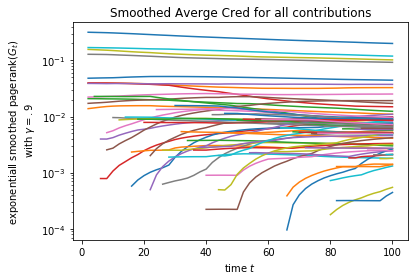

In [66]:
r2df = df[df.substep==2].copy() 
plt.semilogy(r2df.index,make2D('time_weighted_cred', r2df))
plt.title('Smoothed Averge Cred for all contributions')
plt.xlabel('time $t$')
plt.ylabel('exponentiall smoothed pagerank($G_t$)\n with $\gamma=.9$')

Text(0, 0.5, ' $\\sum_{T < t}$ pagerank($G_T$)')

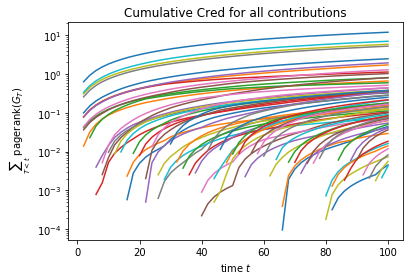

In [67]:
plt.semilogy(r2df.index,make2D('cumulative_cred', r2df))
plt.title('Cumulative Cred for all contributions')
plt.xlabel('time $t$')
plt.ylabel(' $\sum_{T < t}$ pagerank($G_T$)')

In [68]:
#now lets look at just users cred of all 3 types
user_nodes = get_nodes_by_type(nets[-1], 'github/user')
user_names = [nets[-1].nodes[u]['address'][4] for u in user_nodes ]
U = len(user_nodes)
N = len(nets)
user_cred = np.empty((U,N))
user_cumulative_cred = np.empty((U,N))
user_time_weighted_cred = np.empty((U,N))
for i in range(N):
    net = nets[i]
    for u in range(U):
        user = user_nodes[u]
        if user in net.nodes:
            user_cumulative_cred[u,i] = net.nodes[user]['cumulative']
            user_time_weighted_cred[u,i]= net.nodes[user]['time_weighted']
            user_cred[u,i] = net.nodes[user]['score']
        else:
            user_cumulative_cred[u,i] = np.nan
            user_time_weighted_cred[u,i]= np.nan
            user_cred[u,i] = np.nan
            

In [69]:
user_cred.shape

(15, 50)

Text(0, 0.5, 'pagerank($G_t$)')

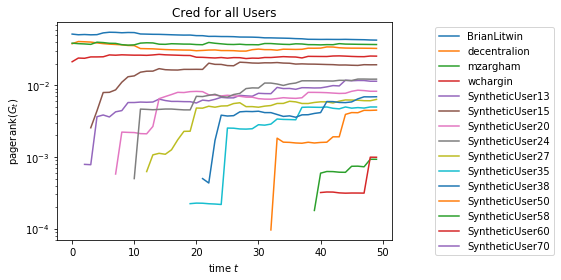

In [70]:
plt.semilogy(range(N),user_cred.T)
plt.legend(user_names, bbox_to_anchor=(1.5, 1))
plt.title('Cred for all Users')
plt.xlabel('time $t$')
plt.ylabel('pagerank($G_t$)')

Text(0, 0.5, '$\\sum_{T < t}$ pagerank($G_T$)')

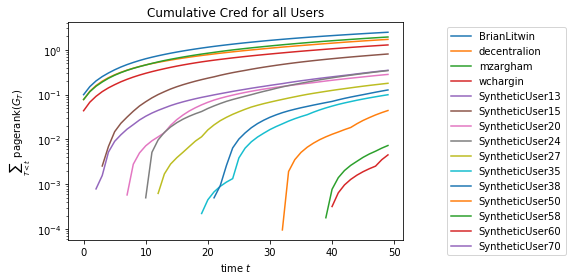

In [71]:
plt.semilogy(range(N),user_cumulative_cred.T)
plt.legend(user_names, bbox_to_anchor=(1.5, 1))
plt.title('Cumulative Cred for all Users')
plt.xlabel('time $t$')
plt.ylabel('$\sum_{T < t}$ pagerank($G_T$)')

Text(0, 0.5, 'smoothed weighted average of pagerank($G_t$)')

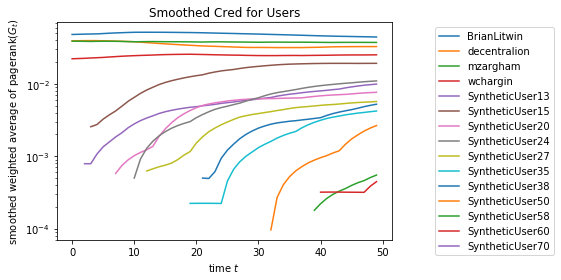

In [72]:
plt.semilogy(range(N),user_time_weighted_cred.T)
plt.legend(user_names, bbox_to_anchor=(1.5, 1))
plt.title('Smoothed Cred for Users')
plt.xlabel('time $t$')
plt.ylabel('smoothed weighted average of pagerank($G_t$)')